<a href="https://colab.research.google.com/github/swilsonmfc/timeseries/blob/master/Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TimeSeries
![](https://i.kym-cdn.com/photos/images/facebook/000/426/861/d7b.png)

# Install

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import xgboost as xgb

# Forecasting Problem
* We're given 120 of the last days of sales
* We'd like to forecast daily sales over the next month
* We'll simulate this by creating & holding 30 observations privately

# Data

## Generate

In [2]:
SIZE = 150
HOLD = 30

X_data = np.arange(SIZE)
y_data = X_data + (5 * np.random.randn(SIZE) + 5)

In [3]:
X = X_data[:SIZE - HOLD]
y = y_data[:SIZE - HOLD]

X_private = X_data[SIZE - HOLD:]
y_private = y_data[SIZE - HOLD:]

## Plot

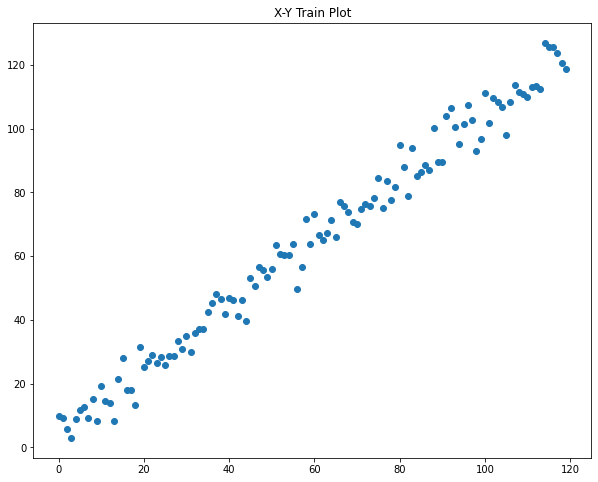

In [4]:
plt.figure(figsize=(10,8))
plt.scatter(X, y)
plt.title('X-Y Train Plot');

# Metrics

In [5]:
def score(y_hat, y_truth):
    mse = mean_squared_error(y_hat, y_truth)
    mae = mean_absolute_error(y_hat, y_truth)
    return (mse, mae)

def scorePrivate(y_hat):
    return score(y_hat, y_private)

# Random Forest

## Random Train - Test Split

In [6]:
X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(X, y, test_size=0.25)

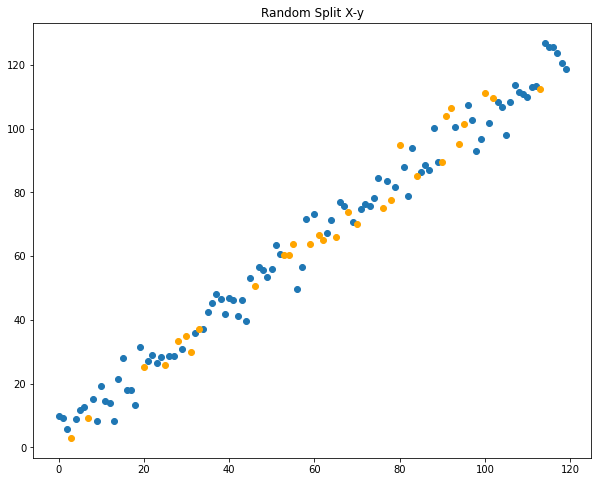

In [7]:
plt.figure(figsize=(10,8))
plt.scatter(X_train_rand, y_train_rand)
plt.scatter(X_test_rand, y_test_rand, color='orange')
plt.title('Random Split X-y');

### Fit

In [8]:
rf = RandomForestRegressor(n_estimators=10)
rf.fit(X_train_rand.reshape(-1,1),  y_train_rand)

RandomForestRegressor(n_estimators=10)

### Hold Out

In [9]:
pred = rf.predict(X_test_rand.reshape(-1,1))
mse_rand, mae_rand = score(pred, y_test_rand)
print(f'MSE {mse_rand:.3f}  MAE {mae_rand:.3f}')

MSE 36.809  MAE 5.034


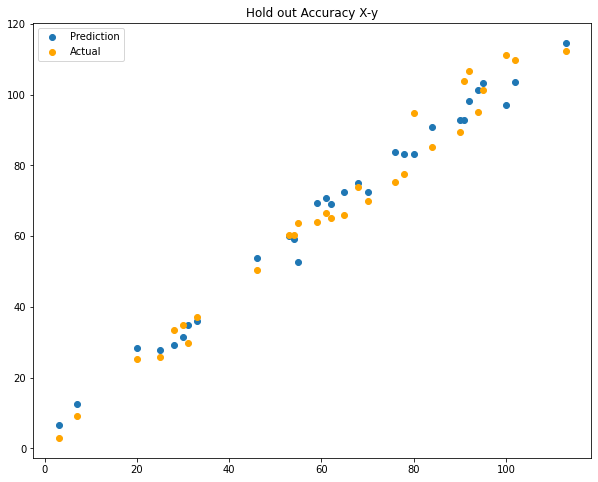

In [10]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_rand, pred, label='Prediction')
plt.scatter(X_test_rand, y_test_rand, color='orange', label='Actual')
plt.legend()
plt.title('Hold out Accuracy X-y');

### Deploy

In [11]:
pred = rf.predict(X_private.reshape(-1,1))
mse_rand_deployed, mae_rand_deployed = scorePrivate(pred)
print(f'Validation: MSE {mse_rand:.3f}  MAE {mae_rand:.3f}')
print(f'Deployed  : MSE {mse_rand_deployed:.3f}  MAE {mae_rand_deployed:.3f}')

Validation: MSE 36.809  MAE 5.034
Deployed  : MSE 477.403  MAE 18.938


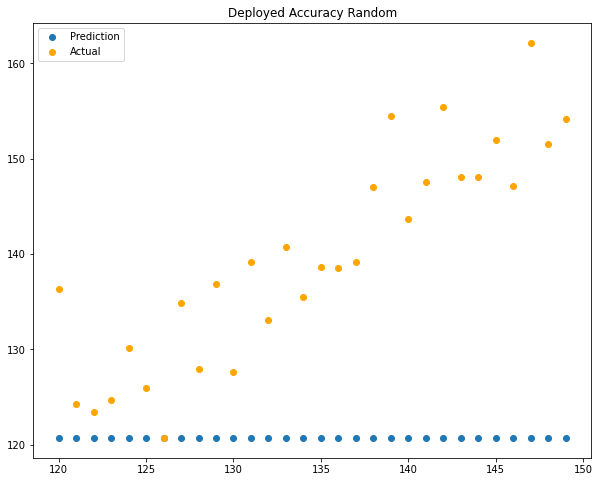

In [12]:
plt.figure(figsize=(10,8))
plt.scatter(X_private, pred, label='Prediction')
plt.scatter(X_private, y_private, color='orange', label='Actual')
plt.legend()
plt.title('Deployed Accuracy Random');

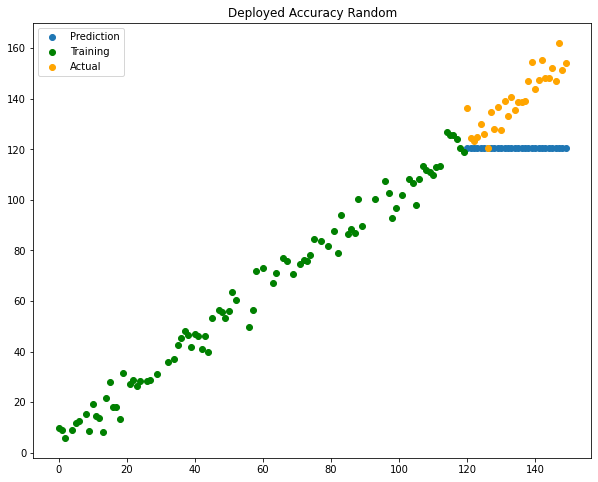

In [13]:
plt.figure(figsize=(10,8))
plt.scatter(X_private, pred, label='Prediction')
plt.scatter(X_train_rand, y_train_rand, color='green', label='Training')
plt.scatter(X_private, y_private, color='orange', label='Actual')
plt.legend()
plt.title('Deployed Accuracy Random');

### Conclusions
* Deployed model was a disaster
* We randomly sampled, and our validation results looked good
* Validation data didn't look like deployed data (some of it was older)
* Let's try again using the last n parts of the data

## Last "N" Split

In [14]:
X_train_last = X[:90]; y_train_last = y[:90]
X_test_last  = X[90:]; y_test_last  = y[90:]

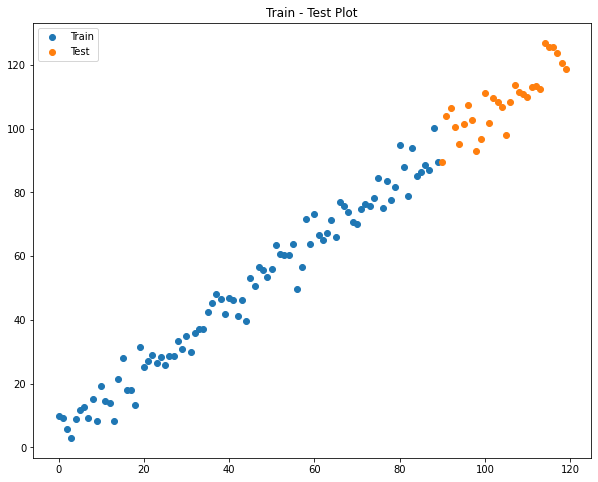

In [15]:
plt.figure(figsize=(10,8))
plt.scatter(X_train_last, y_train_last, label='Train')
plt.scatter(X_test_last, y_test_last, label='Test')
plt.legend()
plt.title('Train - Test Plot');

### Fit

In [16]:
rf = RandomForestRegressor(n_estimators=10)
rf.fit(X_train_last.reshape(-1,1),  y_train_last)

RandomForestRegressor(n_estimators=10)

### Hold Out

In [17]:
pred = rf.predict(X_test_last.reshape(-1,1))
mse_last, mae_last = score(pred, y_test_last)
print(f'Random Holdout  : MSE {mse_rand:.3f}  MAE {mae_rand:.3f}')
print(f'Random Deployed : MSE {mse_rand_deployed:.3f}  MAE {mae_rand_deployed:.3f}')
print(f'Last N Model    : MSE {mse_last:.3f}  MAE {mae_last:.3f}')

Random Holdout  : MSE 36.809  MAE 5.034
Random Deployed : MSE 477.403  MAE 18.938
Last N Model    : MSE 367.444  MAE 16.760


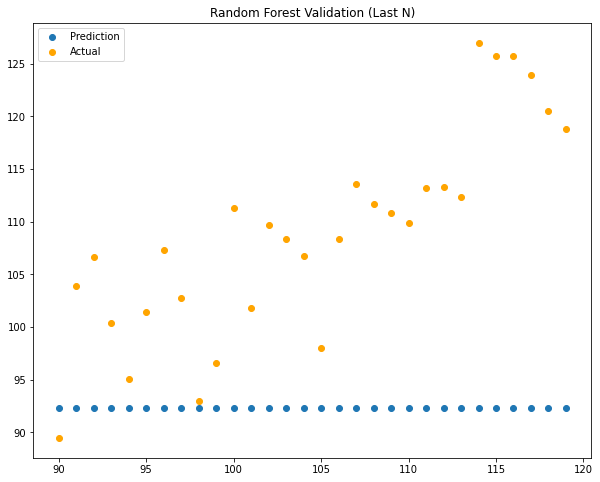

In [18]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_last, pred, label='Prediction')
plt.scatter(X_test_last, y_test_last, color='orange', label='Actual')
plt.legend()
plt.title('Random Forest Validation (Last N)');

### Deploy

In [19]:
pred = rf.predict(X_private.reshape(-1,1))
mse_last_deployed, mae_last_deployed = scorePrivate(pred)
print(f'Validation: MSE {mse_last:.3f}  MAE {mae_last:.3f}')
print(f'Deployed  : MSE {mse_last_deployed:.3f}  MAE {mae_last_deployed:.3f}')

Validation: MSE 367.444  MAE 16.760
Deployed  : MSE 2356.563  MAE 47.306


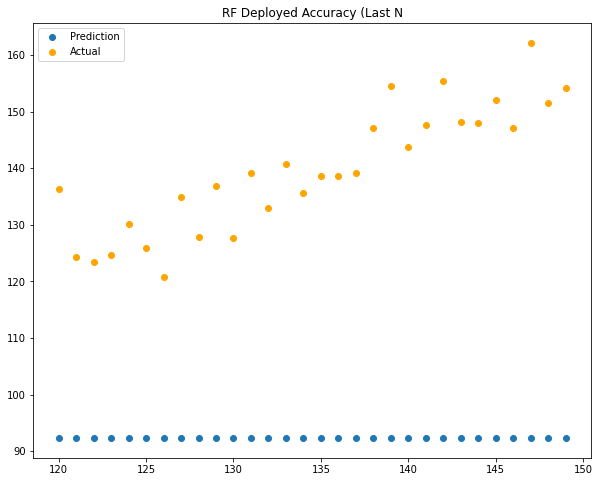

In [20]:
plt.figure(figsize=(10,8))
plt.scatter(X_private, pred, label='Prediction')
plt.scatter(X_private, y_private, color='orange', label='Actual')
plt.legend()
plt.title('RF Deployed Accuracy (Last N');

### Conclusions
* Our validation score was a much better indicator
* For date based dataets, a good strategy involves using last n validation
* Validation sets are everything - you want it to be as close to your target as possible
* Our problem was in the model choice - RandomForest
* A RandomForest can't model trend and forecasts outside of it's trained range
  * RandomForestRegressor predicts the mean of the observations in a leaf node
  * The RandomForest has large X values in a single leaf, and it uses that leaf for all predictions


# XGBoost

In [21]:
boost = xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1)

## Random Train - Test Split

In [22]:
boost.fit(X_train_rand.reshape(-1,1),  y_train_rand)
pred = boost.predict(X_test_rand.reshape(-1,1))
xgb_mse_rand, xgb_mae_rand = score(pred, y_test_rand)
print(f'MSE {xgb_mse_rand:.3f}  MAE {xgb_mae_rand:.3f}')

[09:57:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE 37.067  MAE 5.217


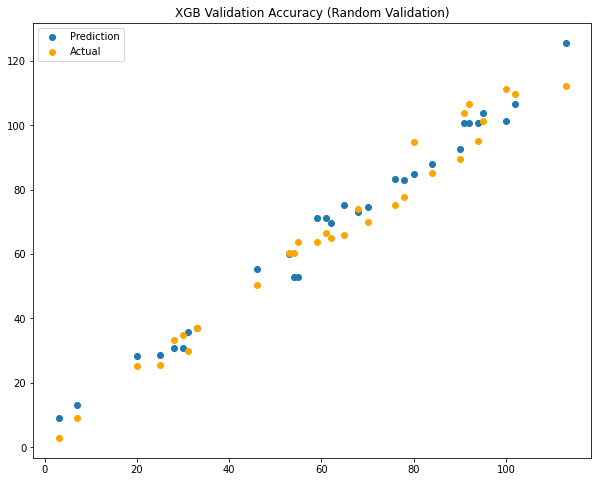

In [23]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_rand, pred, label='Prediction')
plt.scatter(X_test_rand, y_test_rand, color='orange', label='Actual')
plt.legend()
plt.title('XGB Validation Accuracy (Random Validation)');

In [24]:
pred = boost.predict(X_private.reshape(-1,1))
xgb_mse_rand_deployed, xgb_mae_rand_deployed = scorePrivate(pred)
print(f'Validation: MSE {xgb_mse_rand:.3f}  MAE {xgb_mae_rand:.3f}')
print(f'Deployed  : MSE {xgb_mse_rand_deployed:.3f}  MAE {xgb_mae_rand_deployed:.3f}')
print(f'Validation MAE Error {(abs(xgb_mae_rand - xgb_mae_rand_deployed)) * 100.0 / xgb_mae_rand:.2f}%')

Validation: MSE 37.067  MAE 5.217
Deployed  : MSE 547.793  MAE 20.714
Validation MAE Error 297.02%


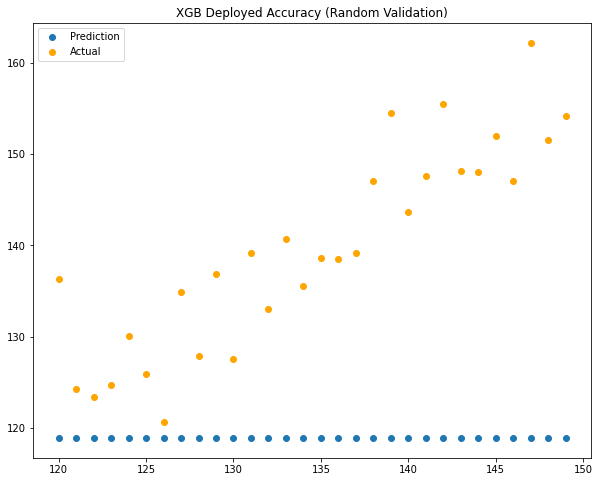

In [25]:
plt.figure(figsize=(10,8))
plt.scatter(X_private, pred, label='Prediction')
plt.scatter(X_private, y_private, color='orange', label='Actual')
plt.legend()
plt.title('XGB Deployed Accuracy (Random Validation)');

## Last "N" Split

In [26]:
boost.fit(X_train_last.reshape(-1,1),  y_train_last)
pred = boost.predict(X_test_last.reshape(-1,1))
xgb_mse_last, xgb_mae_last = score(pred, y_test_last)
print(f'Random Holdout  : MSE {xgb_mse_rand:.3f}  MAE {xgb_mae_rand:.3f}')
print(f'Last N Model    : MSE {xgb_mse_last:.3f}  MAE {xgb_mae_last:.3f}')

[09:57:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Random Holdout  : MSE 37.067  MAE 5.217
Last N Model    : MSE 472.256  MAE 19.477


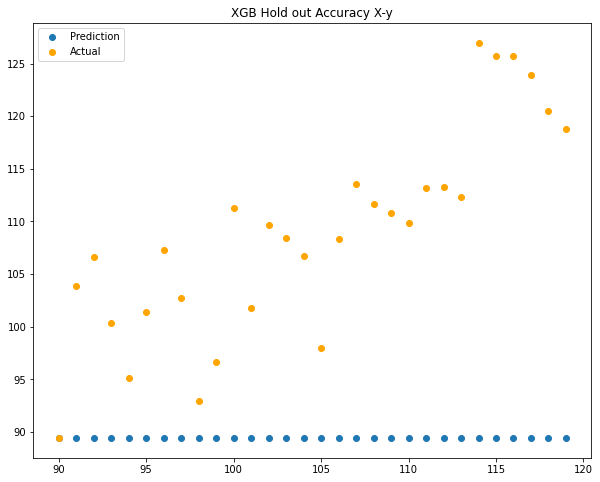

In [27]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_last, pred, label='Prediction')
plt.scatter(X_test_last, y_test_last, color='orange', label='Actual')
plt.legend()
plt.title('XGB Hold out Accuracy X-y');

In [28]:
pred = boost.predict(X_private.reshape(-1,1))
xgb_mse_last_deployed, xgb_mae_last_deployed = scorePrivate(pred)
print(f'Validation: MSE {xgb_mse_last:.3f}  MAE {xgb_mae_last:.3f}')
print(f'Deployed  : MSE {xgb_mse_last_deployed:.3f}  MAE {xgb_mae_last_deployed:.3f}')

Validation: MSE 472.256  MAE 19.477
Deployed  : MSE 2640.117  MAE 50.213


## Conclusion
* XGBoost with gbtree boosted learners can not capture a trend
* Last N hold out / validation set is helpful in catching this problem

# XGBoost - Linear Booster

In [29]:
boost = xgb.XGBRegressor(n_estimators=50, max_depth=2, learning_rate=0.3, booster='gblinear')

## Random Train - Test Split

In [30]:
boost.fit(X_train_rand.reshape(-1,1),  y_train_rand)
pred = boost.predict(X_test_rand.reshape(-1,1))
xgb_lin_mse_rand, xgb_lin_mae_rand = score(pred, y_test_rand)
print(f'MSE {xgb_lin_mse_rand:.3f}  MAE {xgb_lin_mae_rand:.3f}')

[09:57:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE 26.189  MAE 4.144


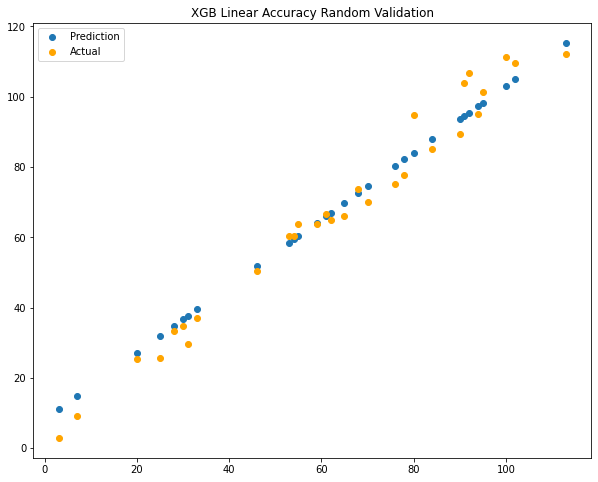

In [31]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_rand, pred, label='Prediction')
plt.scatter(X_test_rand, y_test_rand, color='orange', label='Actual')
plt.legend()
plt.title('XGB Linear Accuracy Random Validation');

In [32]:
pred = boost.predict(X_private.reshape(-1,1))
xgb_lin_mse_rand_deployed, xgb_lin_mae_rand_deployed = scorePrivate(pred)
print(f'Validation: MSE {xgb_lin_mse_rand:.3f}  MAE {xgb_lin_mae_rand:.3f}')
print(f'Deployed  : MSE {xgb_lin_mse_rand_deployed:.3f}  MAE {xgb_lin_mae_rand_deployed:.3f}')
print(f'Validation MAE Error {(abs(xgb_lin_mae_rand - xgb_lin_mae_rand_deployed)) * 100.0 / xgb_lin_mae_rand:.2f}%')

Validation: MSE 26.189  MAE 4.144
Deployed  : MSE 41.578  MAE 4.822
Validation MAE Error 16.36%


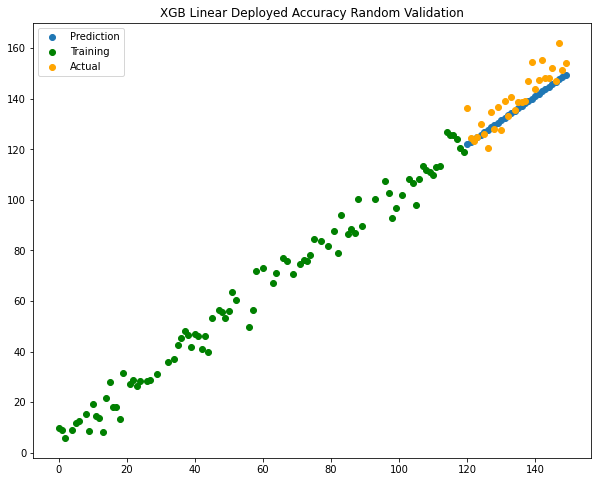

In [33]:
plt.figure(figsize=(10,8))
plt.scatter(X_private, pred, label='Prediction')
plt.scatter(X_train_rand, y_train_rand, color='green', label='Training')
plt.scatter(X_private, y_private, color='orange', label='Actual')
plt.legend()
plt.title('XGB Linear Deployed Accuracy Random Validation');

## Last "N" Split

In [34]:
pred = boost.predict(X_test_last.reshape(-1,1))
xgb_lin_mse_last, xgb_lin_mae_last = score(pred, y_test_last)
print(f'Random Holdout  : MSE {xgb_lin_mse_rand:.3f}  MAE {xgb_lin_mae_rand:.3f}')
print(f'Last N Model    : MSE {xgb_lin_mse_last:.3f}  MAE {xgb_lin_mae_last:.3f}')

Random Holdout  : MSE 26.189  MAE 4.144
Last N Model    : MSE 30.949  MAE 4.434


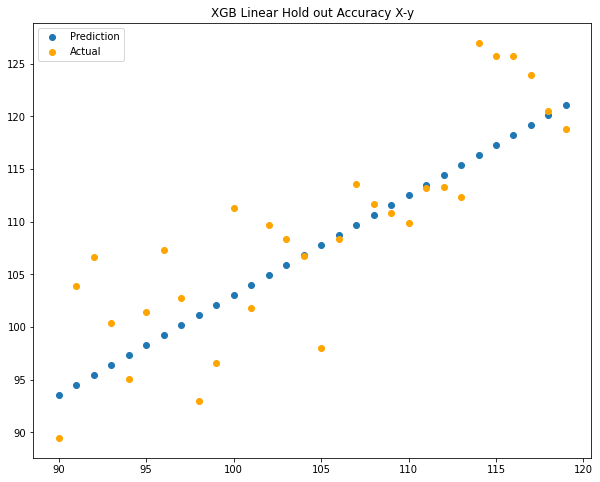

In [35]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_last, pred, label='Prediction')
plt.scatter(X_test_last, y_test_last, color='orange', label='Actual')
plt.legend()
plt.title('XGB Linear Hold out Accuracy X-y');

In [36]:
pred = boost.predict(X_private.reshape(-1,1))
xgb_lin_mse_last_deployed, xgb_lin_mae_last_deployed = scorePrivate(pred)
print(f'Validation: MSE {xgb_lin_mse_last:.3f}  MAE {xgb_lin_mae_last:.3f}')
print(f'Deployed  : MSE {xgb_lin_mse_last_deployed:.3f}  MAE {xgb_lin_mae_last_deployed:.3f}')
print(f'Validation MAE Error {(abs(xgb_lin_mae_last - xgb_lin_mae_last_deployed)) * 100.0 / xgb_lin_mae_last:.2f}%')

Validation: MSE 30.949  MAE 4.434
Deployed  : MSE 41.578  MAE 4.822
Validation MAE Error 8.76%


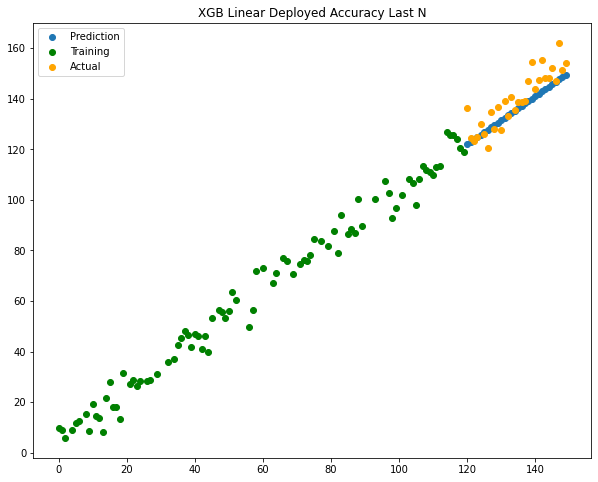

In [37]:
plt.figure(figsize=(10,8))
plt.scatter(X_private, pred, label='Prediction')
plt.scatter(X_train_rand, y_train_rand, color='green', label='Training')
plt.scatter(X_private, y_private, color='orange', label='Actual')
plt.legend()
plt.title('XGB Linear Deployed Accuracy Last N');

## Conclusion
* XGBoost with linear booster can build a trend
* Bring in last n observations in training
* Caution, XGBoost is using a linear regression at each iteration
  * That reduces to a series of affine functions added together (i.e. it's still linear)
  * It can't handle interactions
  * Can't model exponential trends

# Linear Regression
* XGBoost is heavy handed for this simple forecast
* Let's go for parsimony and use a linear regression

## Random Train - Test Split

In [38]:
lr = LinearRegression()
lr.fit(X_train_rand.reshape(-1,1),  y_train_rand)

LinearRegression()

In [39]:
pred = lr.predict(X_test_rand.reshape(-1,1))
lr_mse_rand, lr_mae_rand = score(pred, y_test_rand)
print(f'MSE {lr_mse_rand:.3f}  MAE {lr_mae_rand:.3f}')

MSE 21.296  MAE 3.665


In [40]:
pred = lr.predict(X_private.reshape(-1,1))
lr_mse_rand_deployed, lr_mae_rand_deployed = scorePrivate(pred)
print(f'Validation: MSE {lr_mse_rand:.3f}  MAE {lr_mae_rand:.3f}')
print(f'Deployed  : MSE {lr_mse_rand_deployed:.3f}  MAE {lr_mae_rand_deployed:.3f}')
print(f'Validation MAE Error {(abs(lr_mae_rand - lr_mae_rand_deployed)) * 100.0 / lr_mae_rand:.2f}%')

Validation: MSE 21.296  MAE 3.665
Deployed  : MSE 27.576  MAE 3.901
Validation MAE Error 6.45%


## Last "N" Split

In [41]:
lr = LinearRegression()
lr.fit(X_train_last.reshape(-1,1),  y_train_last)

LinearRegression()

In [42]:
pred = lr.predict(X_test_last.reshape(-1,1))
lr_mse_last, lr_mae_last = score(pred, y_test_last)
print(f'MSE {lr_mse_last:.3f}  MAE {lr_mae_last:.3f}')

MSE 29.076  MAE 4.568


In [43]:
pred = lr.predict(X_private.reshape(-1,1))
lr_mse_last_deployed, lr_mae_last_deployed = scorePrivate(pred)
print(f'Validation: MSE {lr_mse_last:.3f}  MAE {lr_mae_last:.3f}')
print(f'Deployed  : MSE {lr_mse_last_deployed:.3f}  MAE {lr_mae_last_deployed:.3f}')
print(f'Validation MAE Error {(abs(lr_mae_last - lr_mae_last_deployed)) * 100.0 / lr_mae_last:.2f}%')

Validation: MSE 29.076  MAE 4.568
Deployed  : MSE 25.452  MAE 3.930
Validation MAE Error 13.95%


## Conclusion

* We got a better MAE with random compared to last n 
* Our validation tracked to deployed much better with last "N"
* Last "N" is a better validation strategy!

# Wrap

* Linear regression assumes independent and identically distributed data
* We don't have that here, these points have strong correlation with eachother
* Despite the violation we can use Linear Regression if we assume:
  * The series is linear with respect to the dependent variable
  * No perfectly correlated independent variables
  * No constant independent variables
  * The expected value of errors is zero & our variance is independent of time
  * Errors are not correlated with independent variables